In [29]:
from stage1 import *

In [30]:
nframes,natoms,nmols=(0,0,0)

In [31]:
from stage2_2 import * 

In [32]:
stage1

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)

In [33]:
testframe=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro",frame=0)


In [34]:
cf=condenseframe(testframe)

In [35]:
meltframes=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro")
meltframes.xyz=meltframes.xyz*10
global nframes,natoms,nmols 
nframes = meltframes.xyz.shape[0]
natoms = meltframes.topology.residue(0).n_atoms
nmols = meltframes.topology.n_residues
print (nframes,natoms,nmols)
meltframes=meltframes[::1000]

50001 4 592


In [36]:
cf

array([[ 989.73218382, -119.74628944, -197.40942935,    2.28225017,
           0.95225006,    1.95350003],
       [ 989.76849886, -119.73585966, -197.41076634,    1.36549997,
           1.45650005,    2.59900022],
       [ 989.68180471, -119.73857341, -197.40141621,    0.83375001,
           1.77175009,    0.73750007],
       ...,
       [ 989.93611267, -119.77727923, -197.45017153,    2.56474996,
           1.57500005,    2.47574997],
       [ 989.91725164, -119.77881594, -197.44119932,    1.61825013,
           1.92200017,    2.49900007],
       [ 989.9549194 , -119.77415846, -197.44162913,    0.79150009,
           2.24175   ,    2.16525006]])

In [37]:
melt_condensed=condenseAllFrames(meltframes)
graphs_melt_cpu=get_graphs(melt_condensed,"melt")
print(len(graphs_melt_cpu))

100%|██████████| 51/51 [00:02<00:00, 22.19it/s]

30192


In [38]:
torch.save(graphs_melt_cpu,f'./graphs/melt_neigh{n_neigh}.pt')

In [39]:
g = get_graph(cf,1,n_neigh,"cry")

In [40]:
graphs_cpu=graphs_melt_cpu
np.random.shuffle(graphs_cpu)


In [41]:
import os
in_channels = graphs_cpu[0].num_features
out_channels = 5
lr = 1e-4
n_epochs = 40
batch_size=32
test_train_split = 0.8
model_name = "Interex1.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists("./"+model_name) and not force_train:
    model = torch.load("./"+model_name)
    model_loaded = True
else:
    model = VGAE_S2(VariationalGCNEncoder_S2(in_channels, out_channels,batch_size,n_neigh+1),
                    VariationalGCNDecoder_S2(out_channels, in_channels,batch_size,n_neigh+1))

model = model.to(device)
model = model.double()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)


In [42]:
graphs_device = []
for graph in tqdm(graphs_cpu):
    graphs_device.append(graph.to(device))

100%|██████████| 30192/30192 [00:20<00:00, 1451.93it/s]


In [43]:
graphs = graphs_device
total_graphs = len(graphs)


In [44]:
print("Using:",device )
print("total_graphs:", total_graphs)
print("batch Size:" , batch_size)
print("number of batches:",total_graphs//batch_size)
print("Neighbours:",n_neigh)
print("Model\n",model)

Using: cuda
total_graphs: 30192
batch Size: 32
number of batches: 943
Neighbours: 20
Model
 VGAE_S2(
  (encoder): VariationalGCNEncoder_S2(
    (conv1): GATConv(6, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(84, 5, bias=True)
    (mu): Linear(5, 5, bias=True)
    (logstd): Linear(5, 5, bias=True)
  )
  (decoder): VariationalGCNDecoder_S2(
    (inv_transform): Linear(5, 21, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 6, bias=True)
  )
)


In [45]:
split = int(test_train_split * total_graphs)
train_loader = DataLoader(graphs[:split], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graphs[split:], batch_size=batch_size, shuffle=True)

In [46]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()

def train():
    model.train()
    model.zero_grad()
    all_loss_mse = 0
    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        loss = MSE_loss(decoded_x, data.x)
        loss.backward()
        all_loss_mse += float(loss)
        optimizer.step()


    return all_loss_mse/len(train_loader)

In [47]:
def test():
    model.eval()
    model.zero_grad()
    all_loss_mse = 0
    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        loss = MSE_loss(decoded_x, data.x)

        all_loss_mse += float(loss)


    return all_loss_mse/len(test_loader)

In [48]:
train_losses = []
test_losses = []

if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):

        train_loss_mse = train()
        test_loss_mse = test()

        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f}')
        print(f'\tTest: \tMSE Loss: {test_loss_mse:.4f}')

        train_losses.append([train_loss_mse]);
        test_losses.append([test_loss_mse]);

        scheduler.step()
    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	MSE Loss: 133755.5397
	Test: 	MSE Loss: 121692.1869
Epoch: 002
	Train:	MSE Loss: 57806.9188
	Test: 	MSE Loss: 34857.2946
Epoch: 003
	Train:	MSE Loss: 29008.6753
	Test: 	MSE Loss: 22979.3082
Epoch: 004
	Train:	MSE Loss: 20675.8323
	Test: 	MSE Loss: 16374.2930
Epoch: 005
	Train:	MSE Loss: 14145.7657
	Test: 	MSE Loss: 11023.7971
Epoch: 006
	Train:	MSE Loss: 9452.6169
	Test: 	MSE Loss: 7789.6047
Epoch: 007
	Train:	MSE Loss: 7000.5069
	Test: 	MSE Loss: 6398.2581
Epoch: 008
	Train:	MSE Loss: 5967.8073
	Test: 	MSE Loss: 5459.6639
Epoch: 009
	Train:	MSE Loss: 4311.8302
	Test: 	MSE Loss: 2772.8014
Epoch: 010
	Train:	MSE Loss: 1401.5363
	Test: 	MSE Loss: 947.4086
Epoch: 011
	Train:	MSE Loss: 861.8878
	Test: 	MSE Loss: 731.6035
Epoch: 012
	Train:	MSE Loss: 694.8649
	Test: 	MSE Loss: 604.2160
Epoch: 013
	Train:	MSE Loss: 574.8194
	Test: 	MSE Loss: 494.0877
Epoch: 014
	Train:	MSE Loss: 455.6895
	Test: 	MSE Loss: 375.4188
Epoch: 015
	Train:	MSE Loss: 334.9249
	Test: 	MSE Loss: 263

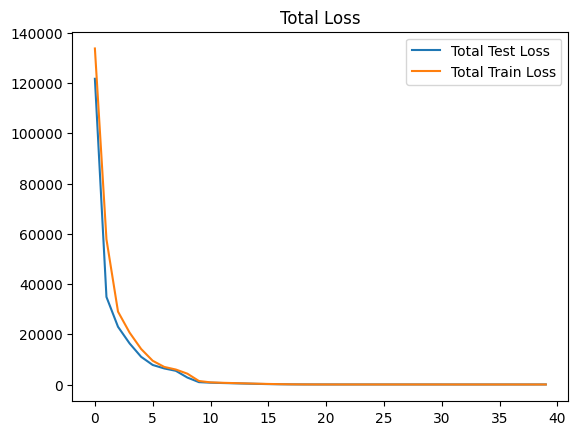

In [49]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

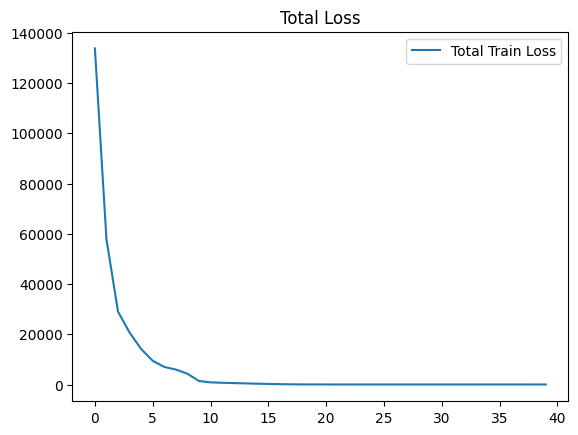

In [50]:
if not model_loaded:
    plt.figure()
    # plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

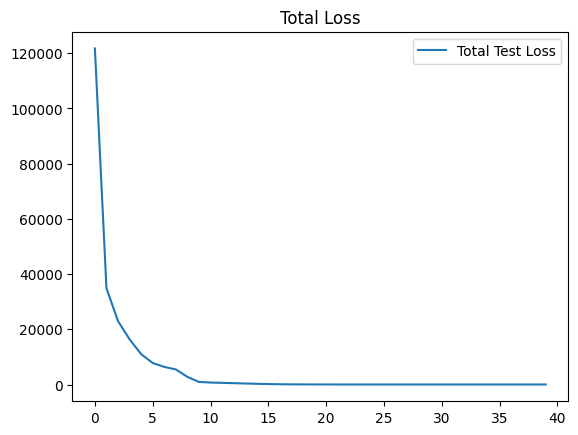

In [51]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    # plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

In [52]:
from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

for ind in range(len(test_loader)):
    test_graph = test_loader.dataset[ind]

    model.double()
    z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
    decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)
    heavy_indices = torch.where(test_graph.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(test_graph.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], test_graph.x[heavy_indices]).detach().cpu().numpy()



    avg1 += Error_wo_s

print("Average Error", avg1/len(test_loader))


Average Error 27.86032348246566


In [53]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
# decoded_feature[0][heavy_indices],input_feature[0][heavy_indices]
len(input_feature[0][heavy_indices])

21

In [54]:
decoded_feature[0][heavy_indices]

tensor([[ 9.8874e+02, -1.1921e+02, -1.9666e+02, -1.2943e-01, -1.5545e-01,
          9.0640e+00],
        [ 9.8873e+02, -1.1961e+02, -1.9726e+02,  4.2780e+00,  6.1742e+00,
          1.0099e+01],
        [ 9.8894e+02, -1.1961e+02, -1.9723e+02,  6.9114e+00,  9.3671e+00,
          1.0817e+01],
        [ 9.8873e+02, -1.1961e+02, -1.9726e+02,  4.3113e+00,  6.2145e+00,
          1.0107e+01],
        [ 9.8874e+02, -1.1961e+02, -1.9726e+02,  4.3600e+00,  6.2734e+00,
          1.0120e+01],
        [ 9.8874e+02, -1.1961e+02, -1.9726e+02,  4.3516e+00,  6.2632e+00,
          1.0118e+01],
        [ 9.8867e+02, -1.1961e+02, -1.9727e+02,  3.9581e+00,  5.7871e+00,
          1.0013e+01],
        [ 9.8883e+02, -1.1961e+02, -1.9725e+02,  4.9180e+00,  6.9485e+00,
          1.0270e+01],
        [ 9.8894e+02, -1.1961e+02, -1.9723e+02,  6.9189e+00,  9.3763e+00,
          1.0819e+01],
        [ 9.8877e+02, -1.1961e+02, -1.9726e+02,  4.5392e+00,  6.4902e+00,
          1.0168e+01],
        [ 9.8887e+02, -1.1961e

In [55]:
input_feature[0][heavy_indices]

tensor([[ 990.0956, -119.6931, -197.5150,    8.2900,   10.6525,   19.5400],
        [ 988.6316, -119.4848, -197.2125,   10.3875,    9.5275,   18.4300],
        [ 989.0709, -119.7559, -197.2468,    6.3075,    9.5100,   21.3175],
        [ 989.0070, -119.5350, -197.3151,    9.5200,   13.2575,   18.6825],
        [ 988.4175, -119.4884, -197.2673,    6.8775,   11.4400,   16.4925],
        [ 989.6282, -119.7929, -197.3505,    5.3850,   12.5175,   19.0200],
        [ 988.0830, -119.5063, -197.0137,    9.8675,   11.2225,   16.2900],
        [ 988.8169, -119.6004, -197.3420,   10.2875,   11.3875,   22.8425],
        [ 989.4501, -119.8090, -197.3652,    7.6100,   14.4425,   20.3775],
        [ 987.9406, -119.4504, -196.9547,    9.4425,    7.7650,   22.0775],
        [ 988.0388, -119.4171, -197.1495,    8.4800,    6.4675,   19.3950],
        [ 989.4151, -119.7803, -197.3700,    4.7550,    8.2600,   19.1100],
        [ 990.3207, -119.9063, -197.5195,    4.3050,   10.3575,   17.6025],
        [ 98

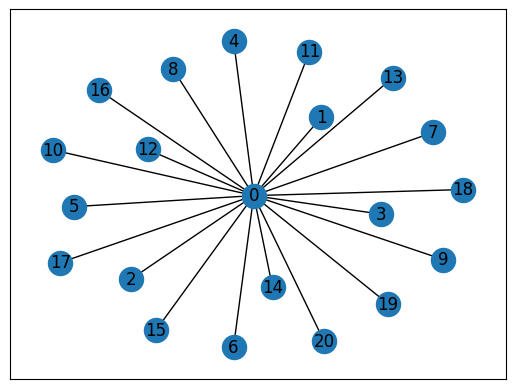

In [56]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
nx.draw_networkx(G)
plt.show()
